<a href="https://colab.research.google.com/github/Smriti398/GRIP-task1/blob/main/Twitter%20Sentiment%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

     |████████████████████████████████| 23.9MB 1.4MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


Requirement already up-to-date: keras in /usr/local/lib/python3.7/dist-packages (2.4.3)
     |████████████████████████████████| 9.9MB 6.5MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.4 which is incompatible.
  Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5


In [1]:
pip install python-Levenshtein

     |████████████████████████████████| 51kB 2.8MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149798 sha256=e218d7df956758cfbe9bdcb93f447569d0386649d5ca6aac35206dea39b1889b
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-Levenshtein


In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5" 
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"


In [5]:
from google.colab import files
uploaded = files.upload()

Saving training.1600000.processed.noemoticon.csv to training.1600000.processed.noemoticon (2).csv


In [6]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [8]:
print("Dataset size:", len(df))

Dataset size: 1162317


In [9]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1.467810e+09,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1.467811e+09,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1.467811e+09,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1.467811e+09,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1.467811e+09,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [11]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 462 ms, sys: 2.35 ms, total: 465 ms
Wall time: 470 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

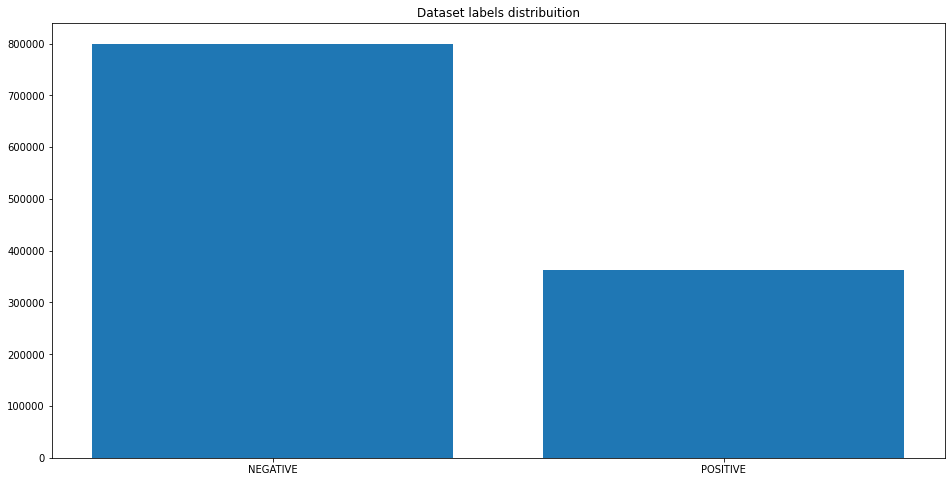

In [12]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [13]:
#PRE PROCESS DATASET
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [14]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [15]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 42.9 s, sys: 62.7 ms, total: 42.9 s
Wall time: 43 s


In [16]:
#Split train and test
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 929853
TEST size: 232464


In [17]:
#Word2Vec
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.65 s, sys: 406 ms, total: 3.06 s
Wall time: 3.05 s


In [18]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8)

2021-05-21 15:07:06,955 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.025)', 'datetime': '2021-05-21T15:07:06.955649', 'gensim': '4.0.1', 'python': '3.7.10 (default, May  3 2021, 02:48:31) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.109+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}


In [19]:
w2v_model.build_vocab(documents)

2021-05-21 15:07:13,620 : INFO : collecting all words and their counts
2021-05-21 15:07:13,622 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-05-21 15:07:13,655 : INFO : PROGRESS: at sentence #10000, processed 72406 words, keeping 13916 word types
2021-05-21 15:07:13,683 : INFO : PROGRESS: at sentence #20000, processed 145327 words, keeping 21528 word types
2021-05-21 15:07:13,712 : INFO : PROGRESS: at sentence #30000, processed 217720 words, keeping 27191 word types
2021-05-21 15:07:13,740 : INFO : PROGRESS: at sentence #40000, processed 290170 words, keeping 32422 word types
2021-05-21 15:07:13,774 : INFO : PROGRESS: at sentence #50000, processed 362641 words, keeping 37271 word types
2021-05-21 15:07:13,802 : INFO : PROGRESS: at sentence #60000, processed 434199 words, keeping 41530 word types
2021-05-21 15:07:13,839 : INFO : PROGRESS: at sentence #70000, processed 507558 words, keeping 45466 word types
2021-05-21 15:07:13,868 : INFO : PROGRESS: at s

In [20]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 25001


In [21]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2021-05-21 15:07:29,257 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 25001 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7', 'datetime': '2021-05-21T15:07:29.256976', 'gensim': '4.0.1', 'python': '3.7.10 (default, May  3 2021, 02:48:31) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.109+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'train'}
2021-05-21 15:07:30,296 : INFO : EPOCH 1 - PROGRESS: at 4.59% examples, 273678 words/s, in_qsize 16, out_qsize 0
2021-05-21 15:07:31,447 : INFO : EPOCH 1 - PROGRESS: at 9.63% examples, 275325 words/s, in_qsize 15, out_qsize 5
2021-05-21 15:07:32,444 : INFO : EPOCH 1 - PROGRESS: at 15.25% examples, 289455 words/s, in_qsize 15, out_qsize 0
2021-05-21 15:07:33,447 : INFO : EPOCH 1 - PROGRESS: at 20.59% examples, 296311 words/s, in_qsize 16, out_qsize 0
2021-05-21 15:07:34,484 : INFO : EPOCH 1 - PROGRESS: at 26.06% examples, 300260 words/s, in_qsize 16, out_qsize 0
2021-05-21 15:07:35,513 : INFO : EPOCH

CPU times: user 19min 25s, sys: 5.06 s, total: 19min 30s
Wall time: 10min 1s


(191288640, 215957504)

In [22]:
w2v_model.wv.most_similar("love")

[('luv', 0.5577350854873657),
 ('loves', 0.5275534391403198),
 ('loved', 0.5092127919197083),
 ('amazing', 0.4759472906589508),
 ('looove', 0.4724307954311371),
 ('miss', 0.4594375789165497),
 ('adore', 0.44783076643943787),
 ('awesome', 0.42001354694366455),
 ('loove', 0.40371033549308777),
 ('loving', 0.40242186188697815)]

In [23]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 228377
CPU times: user 14.7 s, sys: 74.3 ms, total: 14.8 s
Wall time: 14.8 s


In [24]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 20.8 s, sys: 635 ms, total: 21.5 s
Wall time: 21.5 s


**LABEL** **ENCODER**

In [25]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [26]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (929853, 1)
y_test (232464, 1)


In [27]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (929853, 300)
y_train (929853, 1)

x_test (232464, 300)
y_test (232464, 1)


In [28]:
y_train[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0]])

**EMBEDDING LAYER**

In [29]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(228377, 300)


In [30]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

**Build Model**

In [31]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          68513100  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 68,673,601
Trainable params: 160,501
Non-trainable params: 68,513,100
_________________________________________________________________


**COMPILE MODEL**

In [32]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

**CALLBACKS**

In [33]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]



**TRAIN**

In [37]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=1
                    
                    ,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)


818/818 [==============================] - 11504s 14s/step - loss: 0.4381 - accuracy: 0.7941 - val_loss: 0.4140 - val_accuracy: 0.8101


2021-05-21 22:04:50,192 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


CPU times: user 5h 33min 28s, sys: 32min 21s, total: 6h 5min 49s
Wall time: 3h 11min 44s


**EVALUATE**

In [38]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

228/228 [==============================] - 687s 3s/step - loss: 0.4126 - accuracy: 0.8114

ACCURACY: 0.8114116787910461
LOSS: 0.4126356542110443
CPU times: user 19min 12s, sys: 2min 11s, total: 21min 24s
Wall time: 11min 27s


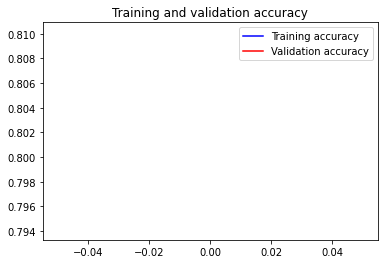

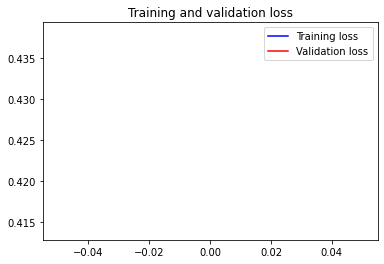

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

**PREDICT**

In [42]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [43]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  


In [45]:
predict("I am confused")

{'elapsed_time': 0.12145185470581055,
 'label': 'NEGATIVE',
 'score': 0.043205976486206055}

In [46]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.11214709281921387,
 'label': 'NEGATIVE',
 'score': 0.23698842525482178}

In [47]:
predict("I love the music")

{'elapsed_time': 0.13424992561340332,
 'label': 'POSITIVE',
 'score': 0.9604392051696777}

In [48]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

30/30 [==============================] - 745s 24s/step
CPU times: user 18min 16s, sys: 5min 7s, total: 23min 24s
Wall time: 12min 25s


In [49]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

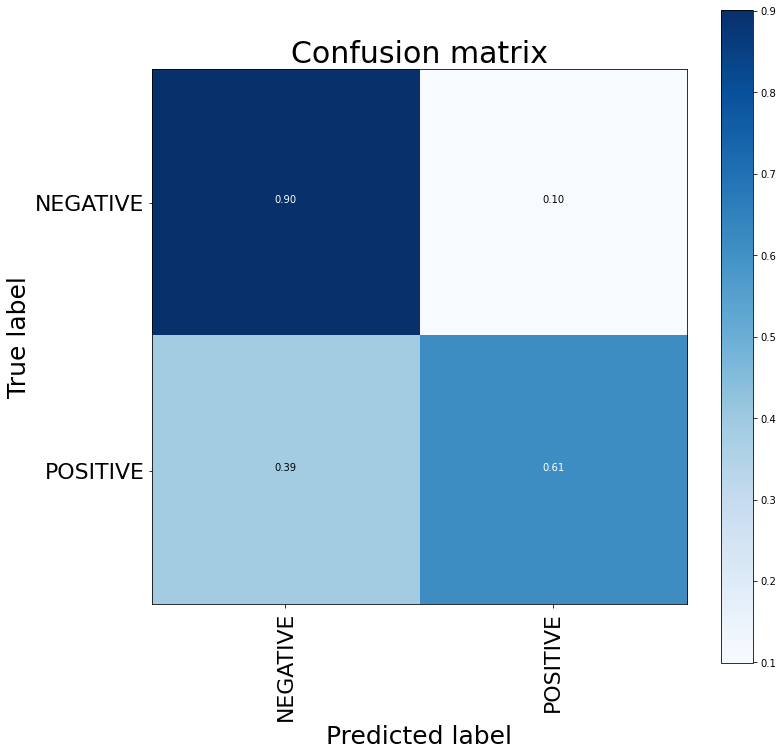

CPU times: user 1.18 s, sys: 43.7 ms, total: 1.22 s
Wall time: 1.34 s


In [50]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [51]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.84      0.90      0.87    160017
    POSITIVE       0.74      0.61      0.67     72447

    accuracy                           0.81    232464
   macro avg       0.79      0.76      0.77    232464
weighted avg       0.81      0.81      0.81    232464



In [52]:
accuracy_score(y_test_1d, y_pred_1d)

0.8114116594397413

In [53]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2021-05-22 00:03:49,740 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'model.w2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-05-22T00:03:49.740032', 'gensim': '4.0.1', 'python': '3.7.10 (default, May  3 2021, 02:48:31) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.109+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-05-22 00:03:49,747 : INFO : not storing attribute cum_table
2021-05-22 00:03:50,311 : INFO : saved model.w2v
